# Medical Data Science Assignment

**University of Tübingen**  
*Course: Medical Data Science*  
*Instructors: Nico Pfeifer*  

**Authors:**  
- Oğuz Ata Çal (Student Number: 6661014)  
- Edward Beach (Student Number: 5451904)

**Date:** [23.11.2023]  
**Assignment:** [Assignment 3]

---

This is the jupiter notebook for the problem 2 of the Assignment 3

### Part a)

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn import svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [33]:
def dirac(x, y):
    return 1 if x == y else 0

def uniform(x, y):
    return 1

def multitask(x, y):
    return uniform(x, y) + dirac(x, y)

def peptide_kernel(peptide1, peptide2):
    # compare each amino acid in peptide1 to each amino acid in peptide2 in the same position and sum the results
    return sum([dirac(x, y) for x, y in zip(peptide1, peptide2)])

def joint_dirac(A, B):
    K_peptide = np.array([[peptide_kernel(a, b) for a in A[:, 0]] for b in B[:, 0]])
    K_all = np.array([[dirac(a, b) for a in A[:, 1]] for b in B[:, 1]])
    return K_peptide * K_all


def joint_multitask(A, B):
    K_peptide = np.array([[peptide_kernel(a, b) for a in A[:, 0]] for b in B[:, 0]])
    K_all = np.array([[multitask(a, b) for a in A[:, 1]] for b in B[:, 1]])
    return K_peptide * K_all

def joint_uniform(A, B):
    K_peptide = np.array([[peptide_kernel(a, b) for a in A[:, 0]] for b in B[:, 0]])
    K_all = np.array([[uniform(a, b) for a in A[:, 1]] for b in B[:, 1]])
    return K_peptide * K_all

### Part b)

In [34]:
# load the binding data
data = pd.read_csv('BindingData.csv')

# show the first 5 rows
print(data.head())

# remove the columns " Epitope ID", " binding information"
data = data.drop(['Epitope ID', ' binding information'], axis=1)

# show the first 5 rows
data.head()

   Epitope ID  binding information       allele  peptide sequence  \
0       52886             Positive  HLA-A*01:01         QYDPVAALF   
1       71650             Positive  HLA-A*01:01         VVEKQSGLY   
2      150319             Positive  HLA-A*01:01         ITEAELTGY   
3      141221             Positive  HLA-A*01:01         ATDSLNNEY   
4       24819             Positive  HLA-A*01:01         HSNLNDATY   

    binding label  
0               1  
1               1  
2               1  
3               1  
4               1  


,allele,peptide sequence,binding label
0,HLA-A*01:01,QYDPVAALF,1
1,HLA-A*01:01,VVEKQSGLY,1
2,HLA-A*01:01,ITEAELTGY,1
3,HLA-A*01:01,ATDSLNNEY,1
4,HLA-A*01:01,HSNLNDATY,1


In [35]:
# split the x and y from the data
x = data.drop([' binding label'], axis=1)
y = data[' binding label']

x = np.array(x)
y = np.array(y)
x = x[:, ::-1]

x[:, 1] = np.array([i[4:] for i in x[:, 1]])
x[:, 1] = np.array([i.replace(':', '') for i in x[:, 1]])

# remove the ":" from the x
x = np.array([[j for j in i if j != ':'] for i in x])

x[:5], x.shape, y[:5], y.shape

(array([['QYDPVAALF', 'A*0101'],
        ['VVEKQSGLY', 'A*0101'],
        ['ITEAELTGY', 'A*0101'],
        ['ATDSLNNEY', 'A*0101'],
        ['HSNLNDATY', 'A*0101']], dtype='<U9'),
 (1297, 2),
 array([1, 1, 1, 1, 1], dtype=int64),
 (1297,))

In [36]:
# Create a list of C values
C_values = [10**i for i in range(-4, 3)]

list_of_kernels = [joint_dirac, joint_multitask, joint_uniform]

# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
print("Number of folds:", kf.get_n_splits(x))
print("------")

roc_values = []

for kernel in list_of_kernels:
    print("Kernel:", kernel.__name__)
    print("------")
    
    kernel_roc_values = []

    for C in C_values:
        scores = []
        true_labels = []
        predicted_labels = []

        for train_index, test_index in kf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            K_train = kernel(x_train, x_train)
            K_test = kernel(x_train, x_test)

            clf = svm.SVC(C=C, kernel='precomputed')
            clf.fit(K_train, y_train)

            # Get predicted labels for the current fold
            y_pred = clf.predict(K_test)

            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)

            # Append the AUC to the list of scores
            scores.append(roc_auc)

            # Append true labels and predicted labels for all folds
            true_labels.extend(y_test)
            predicted_labels.extend(y_pred)

        kernel_roc_values.append((C, fpr, tpr, roc_auc))

        print("Kernel:", kernel.__name__, "C:", C, "score:", np.mean(scores))

    roc_values.append((kernel.__name__, kernel_roc_values))

Number of folds: 10
------
Kernel: joint_dirac
------


Kernel: joint_dirac C: 0.0001 score: 0.5
Kernel: joint_dirac C: 0.001 score: 0.5
Kernel: joint_dirac C: 0.01 score: 0.5017287630402384
Kernel: joint_dirac C: 0.1 score: 0.6140221145283564
Kernel: joint_dirac C: 1 score: 0.5885678421720201
Kernel: joint_dirac C: 10 score: 0.584242075174082
Kernel: joint_dirac C: 100 score: 0.5813781646558351
Kernel: joint_multitask
------
Kernel: joint_multitask C: 0.0001 score: 0.5
Kernel: joint_multitask C: 0.001 score: 0.5
Kernel: joint_multitask C: 0.01 score: 0.5953098320229397
Kernel: joint_multitask C: 0.1 score: 0.6219520998252184
Kernel: joint_multitask C: 1 score: 0.5921920581821802
Kernel: joint_multitask C: 10 score: 0.5774752244904034
Kernel: joint_multitask C: 100 score: 0.5786426378065797
Kernel: joint_uniform
------
Kernel: joint_uniform C: 0.0001 score: 0.5
Kernel: joint_uniform C: 0.001 score: 0.5
Kernel: joint_uniform C: 0.01 score: 0.5498752449176334
Kernel: joint_uniform C: 0.1 score: 0.6175746043494966
Kernel: joint_uniform C: 1 sc

In [37]:
# find the maximum auc for each kernel
max_auc = []
for kernel, roc_value in roc_values:
    max_auc.append((kernel, max(roc_value, key=lambda x: x[3])))

# print the maximum auc for each kernel
for kernel, (C, fpr, tpr, roc_auc) in max_auc:
    print("Kernel:", kernel, "C:", C, "score:", roc_auc)

# find the best score and print it with the kernel and the C value
best_score, best_kernel, best_C = max([(roc_auc, kernel, C) for kernel, (C, fpr, tpr, roc_auc) in max_auc])
print("Best score:", best_score, "Kernel:", best_kernel, "C:", best_C)

Kernel: joint_dirac C: 0.1 score: 0.6186807896003852
Kernel: joint_multitask C: 0.1 score: 0.6267453057294174
Kernel: joint_uniform C: 1 score: 0.6348098218584497
Best score: 0.6348098218584497 Kernel: joint_uniform C: 1


### Part c)

In [38]:
# read supertype.csv
supertype = pd.read_csv('supertype.csv')

supertype.head()

,Supertype,Motif,Genotypes
0,A1,x[TI(SVLM)]xxxxxx[WFY],"A*0101, A*0102, A*2501, A*2601, A*2604, A*3201..."
1,A2,x[LIVMATQ]xxxxxx[LIVMAT],"A*0201, A*0202, A*0203, A*0204, A*0205, A*0206..."
2,A3,x[AILMVST]xxxxxx[RK],"A*0301, A*1101, A*3101, A*3301, A*6801"
3,A24,x[YF(WIVLMT)]xxxxxx[FI(YWLM)],"A*2301, A*2402, A*2403, A*2404, A*3001, A*3002..."
4,B7,x[P]xxxxxx[ALIMVFWY],"B*0702, B*0703, B*0704, B*0705, B*1508, B*3501..."


In [39]:
supertype = supertype.drop(['Motif'], axis=1)

# build a dictionary with genotype as key and supertype as value (genotypes are , separated lists) skip the first row
supertype_dict = {}
for index, row in supertype.iterrows():
    for genotype in row['Genotypes'].split(','):
        supertype_dict[genotype.strip()] = row['Supertype']

supertype_dict


{'A*0101': 'A1',
 'A*0102': 'A1',
 'A*2501': 'A1',
 'A*2601': 'A1',
 'A*2604': 'A1',
 'A*3201': 'A1',
 'A*3601': 'A1',
 'A*4301': 'A1',
 'A*8001': 'A1',
 'A*0201': 'A2',
 'A*0202': 'A2',
 'A*0203': 'A2',
 'A*0204': 'A2',
 'A*0205': 'A2',
 'A*0206': 'A2',
 'A*0207': 'A2',
 'A*6802': 'A2',
 'A*6901': 'A2',
 'A*0301': 'A3',
 'A*1101': 'A3',
 'A*3101': 'A3',
 'A*3301': 'A3',
 'A*6801': 'A3',
 'A*2301': 'A24',
 'A*2402': 'A24',
 'A*2403': 'A24',
 'A*2404': 'A24',
 'A*3001': 'A24',
 'A*3002': 'A24',
 'A*3003': 'A24',
 'B*0702': 'B7',
 'B*0703': 'B7',
 'B*0704': 'B7',
 'B*0705': 'B7',
 'B*1508': 'B7',
 'B*3501': 'B7',
 'B*3502': 'B7',
 'B*3503': 'B7',
 'B*51': 'B7',
 'B*5301': 'B7',
 'B*5401': 'B7',
 'B*5501': 'B7',
 'B*5502': 'B7',
 'B*5601': 'B7',
 'B*5602': 'B7',
 'B*6701': 'B7',
 'B*7801': 'B7',
 'B*1401': 'B27',
 'B*1402': 'B27',
 'B*1503': 'B27',
 'B*1509': 'B27',
 'B*1510': 'B27',
 'B*1518': 'B27',
 'B*2701': 'B27',
 'B*2702': 'B27',
 'B*2703': 'B27',
 'B*2704': 'B27',
 'B*2705': 'B27'

In [40]:
# check if the supertype of all the genotypes are present in the dictionary but print the ones that are not only once
unique_genotypes = set(x[:, 1])
for genotype in unique_genotypes:
    if genotype not in supertype_dict:
        print(genotype)

A*2902


its seen that A\*2902 does not have a supertype, we will remove the datapoints with A\*2902

In [41]:
# remove the genotypes that are not present in the dictionary
x = np.array([i for i in x if i[1] in supertype_dict])
y = np.array([i for i, j in zip(y, x) if j[1] in supertype_dict])

x.shape, y.shape

((1259, 2), (1259,))

In [42]:
# create new x with supertype information as well as all columns of x
x_with_supertype = np.array([[i[0], i[1], supertype_dict[i[1]]] for i in x])

x_with_supertype[:5]

array([['QYDPVAALF', 'A*0101', 'A1'],
       ['VVEKQSGLY', 'A*0101', 'A1'],
       ['ITEAELTGY', 'A*0101', 'A1'],
       ['ATDSLNNEY', 'A*0101', 'A1'],
       ['HSNLNDATY', 'A*0101', 'A1']], dtype='<U9')

In [43]:
# define the multitask kernel with supertype
def multitask_supertype(x, y):
    return multitask(x[0], y[0]) + dirac(x[1], y[1])

# define joint multitask with supertype
def joint_multitask_supertype(A, B):
    K_peptide = np.array([[peptide_kernel(a, b) for a in A[:, 0]] for b in B[:, 0]])
    K_all = np.array([[multitask_supertype(a, b) for a in A[:, 1:]] for b in B[:, 1:]])
    return K_peptide * K_all

In [44]:
# split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_with_supertype, y, test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1007, 3), (252, 3), (1007,), (252,))

In [45]:
# create splits for cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# create a list of C values
C_values = [10**i for i in range(-4, 3)]

# create a list of kernels
list_of_kernels = [joint_multitask_supertype]

for kernel in list_of_kernels:
    print("Kernel:", kernel.__name__)
    print("------")
    
    kernel_roc_values = []

    for C in C_values:
        scores = []
        true_labels = []
        predicted_labels = []

        for train_index, test_index in kf.split(x_train):
            x_train_cv, x_test_cv = x_train[train_index], x_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            K_train = kernel(x_train_cv, x_train_cv)
            K_test = kernel(x_train_cv, x_test_cv)

            clf = svm.SVC(C=C, kernel='precomputed')
            clf.fit(K_train, y_train_cv)

            # Get predicted labels for the current fold
            y_pred = clf.predict(K_test)

            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_test_cv, y_pred)
            roc_auc = auc(fpr, tpr)

            # Append the AUC to the list of scores
            scores.append(roc_auc)

            # Append true labels and predicted labels for all folds
            true_labels.extend(y_test_cv)
            predicted_labels.extend(y_pred)

        kernel_roc_values.append((C, fpr, tpr, roc_auc))

        print("Kernel:", kernel.__name__, "C:", C, "score:", np.mean(scores))

    roc_values.append((kernel.__name__, kernel_roc_values))

Kernel: joint_multitask_supertype
------
Kernel: joint_multitask_supertype C: 0.0001 score: 0.5
Kernel: joint_multitask_supertype C: 0.001 score: 0.5
Kernel: joint_multitask_supertype C: 0.01 score: 0.5535166581303309
Kernel: joint_multitask_supertype C: 0.1 score: 0.595208772130124
Kernel: joint_multitask_supertype C: 1 score: 0.5870307890766212
Kernel: joint_multitask_supertype C: 10 score: 0.5864640871427488
Kernel: joint_multitask_supertype C: 100 score: 0.5860569092968185


In [46]:
# find the maximum auc from the supertype kernel
max_auc = []
for kernel, roc_value in roc_values:
    max_auc.append((kernel, max(roc_value, key=lambda x: x[3])))

# print the maximum auc from the supertype kernel
for kernel, (C, fpr, tpr, roc_auc) in max_auc:
    print("Kernel:", kernel, "C:", C, "score:", roc_auc)

Kernel: joint_dirac C: 0.1 score: 0.6186807896003852
Kernel: joint_multitask C: 0.1 score: 0.6267453057294174
Kernel: joint_uniform C: 1 score: 0.6348098218584497
Kernel: joint_multitask_supertype C: 0.1 score: 0.6330128205128205


Based on the best scores from each ROC curve, it seems that implementing supertype information into the multitask kernel didnt lead to a significant difference. Best AUC score without supertype information: 0.6348098218584497 best AUC score with supertype information: 0.6330128205128205

### Part d)

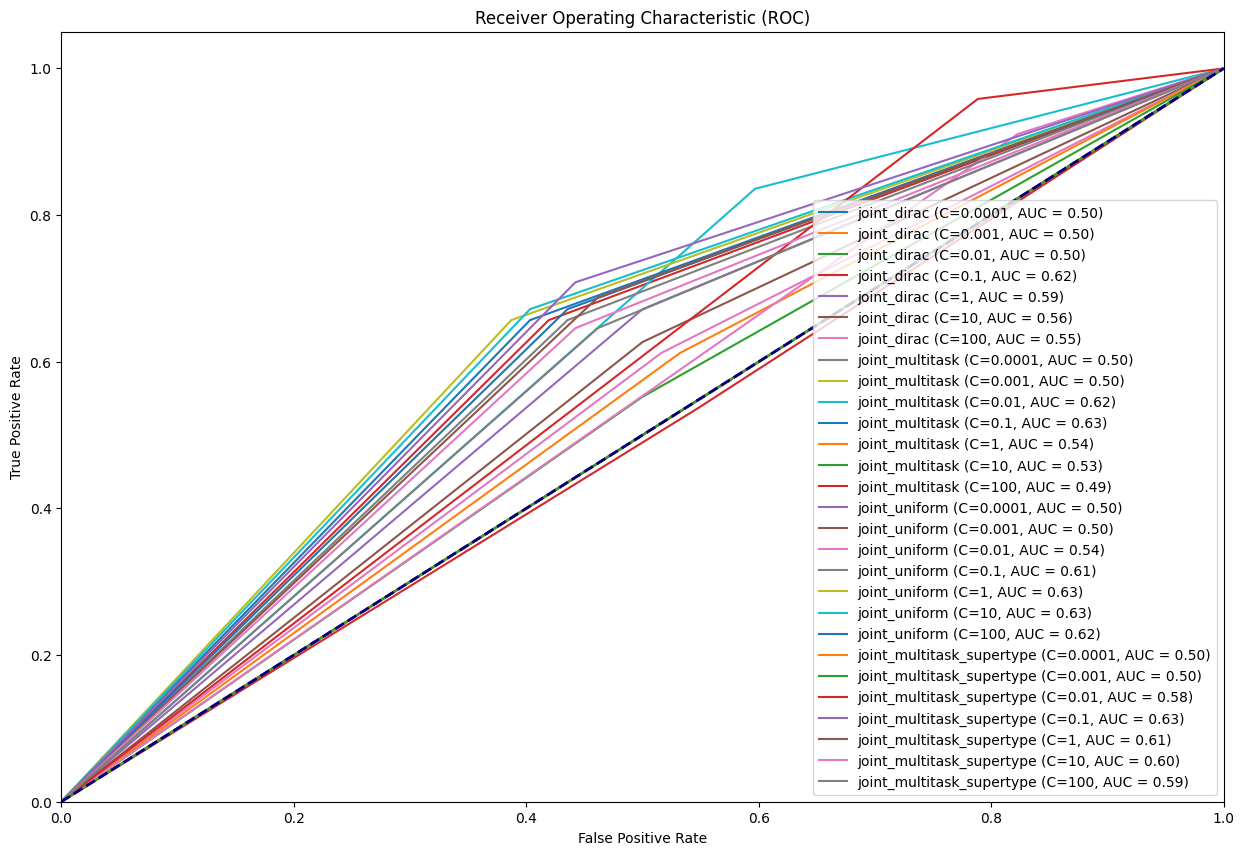

In [49]:
# Plot all ROC curves
plt.figure(figsize=(15, 10))

for kernel_name, kernel_roc_values in roc_values:
    for C, fpr, tpr, roc_auc in kernel_roc_values:
        plt.plot(fpr, tpr, label=f'{kernel_name} (C={C}, AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

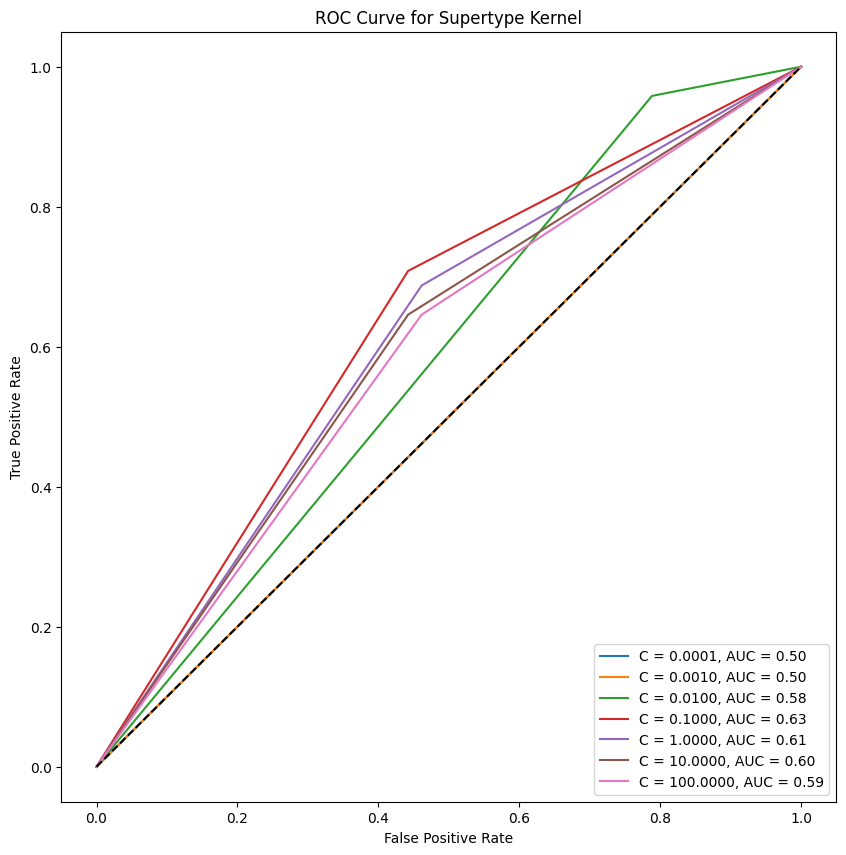

In [48]:
# plot the ROC curve for the supertype kernel
plt.figure(figsize=(10, 10))
for kernel, roc_value in roc_values:
    if kernel == 'joint_multitask_supertype':
        for C, fpr, tpr, roc_auc in roc_value:
            plt.plot(fpr, tpr, label='C = %0.4f, AUC = %0.2f' % (C, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Supertype Kernel')
plt.show()

It can be seen that first of all, low values of C fix the AUC to 0.5 and make it a random classifier. C values higher than 0.01 lead to a meaningfull result. The C value of 1 lead to the best AUC result for the SVM without the dirac kernel using supertype information of 0.6330128205128205 and the C value of 0.1 lead to the best result when using the supertype information of 0.6348098218584497. The C values between 0.1 and 1 seem the best for all kernels.

### Part e)

Accuracy simply calculates the percentage of correctly classified instances out of the total instances. It is a straightforward measure but may not be suitable for imbalanced datasets, where one class significantly outnumbers the other. In such cases, a high accuracy score may be misleading, as the model might be just predicting the majority class.

On the other hand, AUC is a metric that evaluates the model's ability to distinguish between positive and negative instances across various threshold values. It represents the area under the curve of the Receiver Operating Characteristic (ROC) plot, which illustrates the trade-off between sensitivity and specificity. AUC is particularly useful when dealing with imbalanced datasets because it considers the overall performance of the model across different classification thresholds.

Discrepancies between AUC and accuracy can arise when the dataset is imbalanced or when the cost of misclassifying one class is much higher than the other. A model may achieve high accuracy by correctly predicting the majority class but might have a lower AUC if it struggles to distinguish between the classes effectively.